In [1]:
import pandas as pd
import warnings 
from sklearn.preprocessing import StandardScaler

x= pd.read_excel('./data.xls')

# Feature that we want to predict

In [ ]:
#Feature='Followers Growth'
Feature='Engagemnet Rate'#'Followers'#

# Getting Usernames

In [2]:
usernames = x['User Name']
usernames.drop_duplicates()

0            nglkante
52          kurtzouma
104       benchilwell
156        timowerner
208      masonmount10
260      kaihavertz29
312         cmpulisic
364         calteck10
416    billygilmourrr
468           hziyech
520        edou_mendy
Name: User Name, dtype: object

# Set User Size, Window size and number of month that we need to predict

In [3]:
x=x[x['User Name']=='cmpulisic']
window_size = 16
month = 6

# Cleaning and preparing Data

In [4]:
x[Feature] = x[Feature].replace('-', '')
x[Feature]= x[Feature].convert_dtypes(float)
x[Feature]=pd.to_numeric(x[Feature], downcast="float")

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
#x=x[x['User Name']=='edou_mendy']

In [7]:
def rm_bad_cols(x):
    x = x.dropna(thresh=x.shape[0]*0.5,how='all',axis=1)
    colsize = len(x.columns)
    i=0
    while (i < colsize):
        y=x.iloc[:,[i]]
        l=len(y[y[y.columns[0]] == 0])
        c=len(y[y[y.columns[0]] == '0'])
        #print(x.columns[i],l,len(x),l/len(x))
        if (l/(len(x))) > 0.6 or (c/(len(x))) > 0.6:
            x.__delitem__(y.columns[0])
            colsize = len(x.columns)
            i = i-1
        i = i+1
    return x

In [8]:
xx = rm_bad_cols(x)
xx['Beginning Of Interval'] = pd.to_datetime(xx['Beginning Of Interval'], format='%Y%m%d')

/Users/bobakhossainkhani/opt/anaconda3/envs/Data/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
def strip_no_numeric_cols(_df):
    cols = list(_df.select_dtypes(include=['object', 'string']).columns)
    _df = _df.drop(columns=cols)
    return _df

In [10]:
cleaned_xx = strip_no_numeric_cols(xx)
#cleaned_xx

In [11]:
xx=cleaned_xx.fillna(xx.mean())

/Users/bobakhossainkhani/opt/anaconda3/envs/Data/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [12]:
X = cleaned_xx['Beginning Of Interval']
Y1 = xx[Feature]
#Y2 = cleaned_xx['Engagemnet Rate']

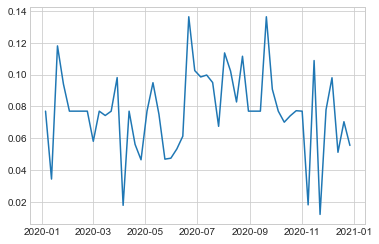

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot(X, Y1);
#ax.plot(X, Y2);

# Correlation between features

<AxesSubplot:>

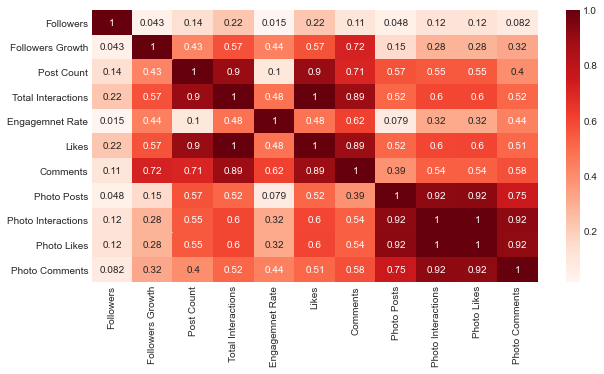

In [14]:
#Using Pearson Correlation
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,5))

cor = xx.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, ax =ax)

# Moving Average

In [15]:
i = 0
#window_size = 12
moving_averages = []
while i < len(xx[Feature]) - window_size + 1:
    this_window = xx[Feature][i : i + window_size]

    window_average = sum(this_window) / window_size
    moving_averages.append(window_average)
    i += 1
    #print(i)

for i in range(int(window_size/2)):
    moving_averages = [0]+moving_averages
while len(xx)>len(moving_averages):
    moving_averages.append(0)
xx['MA'] = moving_averages
#print(moving_averages)
#xx['MA']

In [16]:
Sma = []
i=int(window_size/2)
while i < len(xx[Feature]) - int(window_size/2):
    this_window = xx[Feature][i : i + 2]
    sma = sum(this_window) / 2
    Sma.append(sma)
    i += 1
    #print(i)

for i in range(int(window_size/2)):
    Sma = [0]+Sma
while len(xx)>len(Sma):
    Sma.append(0)
#print(moving_averages)
xx['SMA'] = Sma

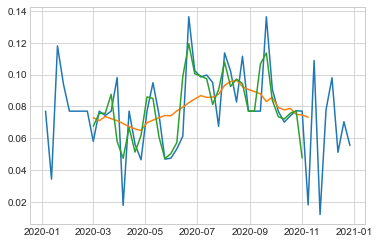

In [17]:
xx.loc[xx['MA'] == 0,'MA'] = np.nan
xx.loc[xx['SMA'] == 0,'SMA'] = np.nan


fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot(X, Y1);
#ax.plot(X, Y2);
ax.plot(X, xx['MA']);
ax.plot(X, xx['SMA']);

# Irrigularity and Seasonality

In [18]:
xx['ItSt'] = (xx[Feature])/(xx['SMA'])

In [19]:
ind = []
for i in range(len(xx)):
    ind.append(i)
xx['index'] = ind

In [20]:
s = xx['ItSt'].copy()
N = int(window_size)
print(N)
from numpy import inf
s[s == inf] = 0
s = s.reset_index()
del s['index']
St = s.groupby(s.index % N).mean()
St = St.to_numpy()
NSt = []
NStt = []
for i in range(int(len(xx)/N)+1):
    NSt = np.append(NSt,St)
#while (len(NSt)>len(xx)):
NStt = NSt[0:len(xx)]
xx['St'] = NStt
#xx['St']
#St

16


In [21]:
len(NStt)

52

In [22]:
xx['Seasonalize'] = (xx[Feature])/(xx['St'])

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
x= xx['index'].to_numpy()
y = xx[Feature].to_numpy()
x = x.reshape(-1,1)

# Regression Coefs

In [25]:
model = LinearRegression().fit(x, y)

In [26]:
model.coef_,model.intercept_

(array([-1.95059665e-06]), 0.07707342444087753)

In [27]:
xx['Tt'] = (model.intercept_)+(model.coef_*xx['index'])

In [28]:
xx['Forecast'] = xx['St']*xx['Tt']
#xx['St'],xx['Tt']

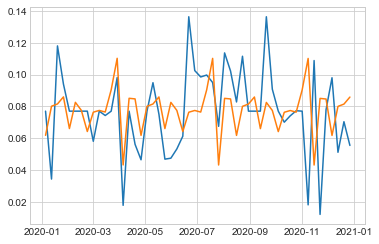

In [29]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 10, 1000)
ax.plot(X, Y1);
#ax.plot(X, Y2);
ax.plot(X, xx['Forecast']);

# Generating next months time data for forecasting

In [30]:
from datetime import datetime

In [31]:
#how many months want to predict
#month = 6
index= []
for i in range (len(xx),len(xx)+month*4):
    index.append(i)

In [32]:
yy = pd.DataFrame()

In [33]:
numOfPer = month*4
N = int(month)
St = xx['St'][0:numOfPer]
NSt = []
yy['St'] = St

In [34]:
#yy = pd.DataFrame()
yy['date'] = pd.date_range(start=X.iloc[51],end='2021-'+str(month)+'-1', periods = month*4)
yy['Tt'] = (model.intercept_)+(model.coef_*index)
yy['Forecast'] = yy['St']*yy['Tt']

#yy

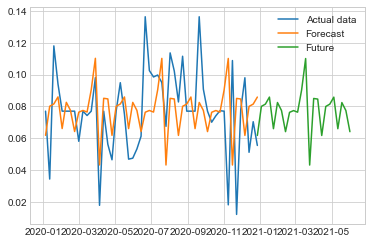

In [35]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 10, 1000)
ax.plot(X, Y1,label='Actual data');
ax.plot(X, xx['Forecast'],label='Forecast');
ax.plot(yy['date'], yy['Forecast'],label='Future');
leg = ax.legend();

In [36]:
(abs(xx[Feature]-xx['Forecast'])/xx[Feature]).mean()

0.4702349953911111

In [37]:
from sklearn.metrics import r2_score

In [38]:
xx[Feature].to_numpy()

array([0.07702368, 0.0344    , 0.118     , 0.094     , 0.07702368,
       0.07702368, 0.07702368, 0.07702368, 0.0581    , 0.07702368,
       0.0743    , 0.07702368, 0.0981    , 0.0179    , 0.07702368,
       0.0562    , 0.0465    , 0.07702368, 0.0949    , 0.0751    ,
       0.0469    , 0.0475    , 0.0533    , 0.0613    , 0.1363    ,
       0.1025    , 0.0985    , 0.0997    , 0.095     , 0.0675    ,
       0.1136    , 0.1022    , 0.0828    , 0.1115    , 0.07702368,
       0.07702368, 0.07702368, 0.1363    , 0.0908    , 0.07702368,
       0.0701    , 0.0741    , 0.0773    , 0.07702368, 0.0182    ,
       0.1088    , 0.0122    , 0.0779    , 0.098     , 0.0512    ,
       0.0704    , 0.0555    ], dtype=float32)

# r2_score

In [39]:
r2_score(xx[Feature],xx['Forecast'])

-0.19676242447188352